In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy
from sklearn.datasets import load_svmlight_file
import time
import warnings
from oracles import create_log_reg_oracle
from optimization import gradient_descent, newton

np.random.seed(24)
warnings.filterwarnings('ignore')


In [9]:
def load_dataset(dataset_name):
    dataset_files = {
        'w8a': 'w8a.txt',
        'gisette': 'gisette_scale.bz2',
        'real-sim': 'real-sim.bz2'
    }
    
    filename = dataset_files.get(dataset_name)
    
    if not filename:
        return None, None
    
    print(f"  Загрузка: {filename}")
    
    try:
        A, b_original = load_svmlight_file(filename)
        
        print(f"    Загружено: {A.shape[0]} объектов, {A.shape[1]} признаков")
        
        unique_labels = np.unique(b_original)
        
        if len(unique_labels) == 2:
            if 0 in unique_labels and 1 in unique_labels:
                b = np.where(b_original == 0, -1, 1)
            else:
                b = np.where(b_original == unique_labels[0], -1, 1)
        else:
            b = np.where(b_original == unique_labels[0], -1, 1)
        
        return A, b
        
    except Exception as e:
        print(f"  Ошибка: {str(e)}")
        return None, None

In [10]:
gd_params = {
    'tolerance': 1e-3,
    'max_iter': 30,
    'line_search_options': {'method': 'Armijo', 'c1': 1e-4, 'alpha_0': 1.0},
    'trace': True,
    'display': False
}

newton_params = {
    'tolerance': 1e-3,
    'max_iter': 10,
    'line_search_options': {'method': 'Constant', 'c': 0.5},
    'trace': True,
    'display': False
}

print("Параметры:")
print(f"Градиентный спуск: tol={gd_params['tolerance']}, max_iter={gd_params['max_iter']}")
print(f"Метод Ньютона: tol={newton_params['tolerance']}, max_iter={newton_params['max_iter']}")

Параметры:
Градиентный спуск: tol=0.001, max_iter=30
Метод Ньютона: tol=0.001, max_iter=10


In [11]:
def run_experiment_fast(dataset_name):
    print(f"ДАТАСЕТ: {dataset_name}")
    print(f"{'-'*85}")
    
    A, b = load_dataset(dataset_name)
    
    if A is None or b is None:
        return None
    
    m, n = A.shape
    regcoef = 1.0 / m
    
    print(f"\nХарактеристики:")
    print(f"  m: {m:,}")
    print(f"  n: {n:,}")
    print(f"  λ: {regcoef:.6e}")
    
    oracle = create_log_reg_oracle(A, b, regcoef, oracle_type='usual')
    x0 = np.zeros(n)
    
    skip_newton = (n > 1000)
    
    print(f"\n[1] Градиентный спуск...")
    gd_start = time.time()
    x_gd, msg_gd, history_gd = gradient_descent(oracle, x0, **gd_params)
    gd_time = time.time() - gd_start
    
    print(f"  Результат: {msg_gd}")
    print(f"  Время: {gd_time:.2f} сек")
    
    if history_gd and 'func' in history_gd:
        print(f"  Итераций: {len(history_gd['func'])}")
    
    newton_result = None
    newton_time = 0
    
    if not skip_newton:
        print(f"\n[2] Метод Ньютона...")
        newton_start = time.time()
        x_newton, msg_newton, history_newton = newton(oracle, x0, **newton_params)
        newton_time = time.time() - newton_start
        
        print(f"  Результат: {msg_newton}")
        print(f"  Время: {newton_time:.2f} сек")
        
        if history_newton and 'func' in history_newton:
            print(f"  Итераций: {len(history_newton['func'])}")
        
        newton_result = {
            'history': history_newton, 
            'time': newton_time, 
            'msg': msg_newton
        }
    else:
        print(f"\n[2] Метод Ньютона пропущен (n={n:,}>1000)")
    
    return {
        'dataset': dataset_name,
        'm': m,
        'n': n,
        'gd': {'history': history_gd, 'time': gd_time, 'msg': msg_gd},
        'newton': newton_result,
        'skip_newton': skip_newton
    }

In [13]:
print("ЗАПУСК ЭКСПЕРИМЕНТА")
print("-"*85)

datasets_to_run = ['w8a']

results = {}
completed = 0

for dataset in datasets_to_run:
    print(f"\nЭКСПЕРИМЕНТ: {dataset}")
    start_time = time.time()
    result = run_experiment_fast(dataset)
    
    if result:
        results[dataset] = result
        completed += 1
        elapsed = time.time() - start_time
        print(f"\n{dataset} завершен за {elapsed:.1f} секунд")
    
    print("-"*85)

print(f"\nЭКСПЕРИМЕНТ ЗАВЕРШЕН")
print(f"Обработан 1 датасет: w8a")

ЗАПУСК ЭКСПЕРИМЕНТА
-------------------------------------------------------------------------------------

ЭКСПЕРИМЕНТ: w8a
ДАТАСЕТ: w8a
-------------------------------------------------------------------------------------
  Загрузка: w8a.txt
    Загружено: 49749 объектов, 300 признаков

Характеристики:
  m: 49,749
  n: 300
  λ: 2.010091e-05

[1] Градиентный спуск...
  Результат: iterations_exceeded
  Время: 0.56 сек
  Итераций: 30

[2] Метод Ньютона...
  Результат: iterations_exceeded
  Время: 0.42 сек
  Итераций: 10

w8a завершен за 1.2 секунд
-------------------------------------------------------------------------------------

ЭКСПЕРИМЕНТ ЗАВЕРШЕН
Обработан 1 датасет: w8a


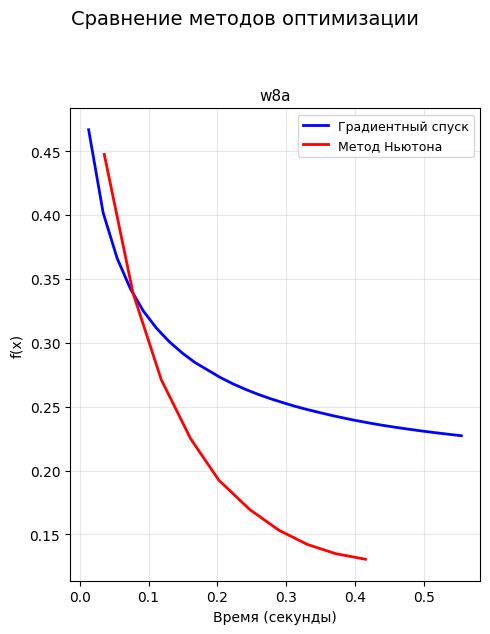

In [14]:
if results:
    n_plots = len(results)
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 6))
    
    if n_plots == 1:
        axes = [axes]
    
    for idx, dataset in enumerate(results.keys()):
        r = results[dataset]
        ax = axes[idx]
        
        if r['gd']['history'] and 'time' in r['gd']['history'] and 'func' in r['gd']['history']:
            time_gd = np.array(r['gd']['history']['time'])
            func_gd = np.array(r['gd']['history']['func'])
            ax.plot(time_gd, func_gd, 'b-', linewidth=2, label='Градиентный спуск')
        
        if r['newton'] and r['newton']['history'] and 'time' in r['newton']['history'] and 'func' in r['newton']['history']:
            time_newton = np.array(r['newton']['history']['time'])
            func_newton = np.array(r['newton']['history']['func'])
            ax.plot(time_newton, func_newton, 'r-', linewidth=2, label='Метод Ньютона')
        
        ax.set_xlabel('Время (секунды)', fontsize=10)
        ax.set_ylabel('f(x)', fontsize=10)
        title = f'{dataset}'
        if r['skip_newton']:
            title += '\n(только ГС)'
        ax.set_title(title, fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
    
    plt.suptitle('Сравнение методов оптимизации', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

In [15]:
if results:
    print("РЕЗУЛЬТАТЫ")
    print("-"*85)
    
    print(f"\n{'Датасет':<10} | {'Метод':<18} | {'Время':<8} | {'Итер.':<6} | {'Улучшение f(x)':<15}")
    print("-"*85)
    
    for dataset in results.keys():
        r = results[dataset]
        
        if r['gd']['history'] and 'func' in r['gd']['history']:
            time_gd = f"{r['gd']['time']:.1f}"
            iter_gd = len(r['gd']['history']['func'])
            if iter_gd > 0:
                f_start = r['gd']['history']['func'][0]
                f_end = r['gd']['history']['func'][-1]
                improvement = f"{(f_start-f_end)/abs(f_start)*100:.1f}%"
            else:
                improvement = "—"
        else:
            time_gd, iter_gd, improvement = '—', '—', '—'
        
        print(f"{dataset:<10} | {'Градиентный спуск':<18} | {time_gd:<8} | {iter_gd:<6} | {improvement:<15}")
        
        if r['newton'] and r['newton']['history'] and 'func' in r['newton']['history']:
            time_newton = f"{r['newton']['time']:.1f}"
            iter_newton = len(r['newton']['history']['func'])
            if iter_newton > 0:
                f_start = r['newton']['history']['func'][0]
                f_end = r['newton']['history']['func'][-1]
                improvement = f"{(f_start-f_end)/abs(f_start)*100:.1f}%"
            else:
                improvement = "—"
            
            print(f"{dataset:<10} | {'Метод Ньютона':<18} | {time_newton:<8} | {iter_newton:<6} | {improvement:<15}")
        elif r['skip_newton']:
            print(f"{dataset:<10} | {'Метод Ньютона':<18} | {'пропущен':<8} | {'—':<6} | {'n слишком велико':<15}")
        
        print("-"*85)
    
    total_time = sum(r['gd']['time'] for r in results.values())
    print(f"\nОбщее время: {total_time:.1f} сек ({total_time/60:.1f} мин)")

РЕЗУЛЬТАТЫ
-------------------------------------------------------------------------------------

Датасет    | Метод              | Время    | Итер.  | Улучшение f(x) 
-------------------------------------------------------------------------------------
w8a        | Градиентный спуск  | 0.6      | 30     | 51.3%          
w8a        | Метод Ньютона      | 0.4      | 10     | 70.8%          
-------------------------------------------------------------------------------------

Общее время: 0.6 сек (0.0 мин)
